# [E17] 프로젝트 - Movielens 영화 SBR
 - Session Based Recommendation 시스템
 - Session Id대신 UserID항목, Rating정보 포함, Time항목 UTC Time포함

## Data Load

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [2]:
# 시간 변환
import datetime, time
times = data["Time"] 
tmp_list = [] 
for time in times: 
    tmp_date = dt.datetime.fromtimestamp(time)
    tmp_list.append(tmp_date)
data["Time"] = tmp_list 
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


In [3]:
# 추천 시스템 구축할때 가장 먼저 확인해 볼 것은 유저수(세션수)와 아이템 입니다.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

유저 숫자가 6040개, 아이템 숫자는 3706개가 됩니다.
이 수치가 유저의 수가 6040명이라는 것은 아닙니다. 같은 유저가 여러 개의 유저아이디를 만들수도 있기 때문입니다.

## Session Length
 - UserID당 userID를 공유하는 데이터 row개수 의미 --> session length란 해당 세션의 사용자가 그 세션동안 몇번의 액션 취했는가 평점리뷰 횟수

In [4]:
# session length란 같은 sessionID를 공유하는 데이터 row의 개수를 의미
# sessionID란 브라우저에서 웹서버로 접속`할때 항상 포함하게 되는 유저 구분자
# 최소한 특정 사용자의 행동을 session ID 기준으로 모아서 분류해낼 수는 있습니다. 
# 따라서 session length란 해당 세션의 사용자가 그 세션동안 몇번의 액션취했는가 의미
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
session_length.min(), session_length.max()

(20, 2314)

In [7]:
session_length.quantile(0.999)

1343.181000000005

#### 각 세션의 길이는 보통 96~166 정도 99.9% 세션은 길이가 1343 이하 
#### 2314 인 세션은 뭔가 이상함!
 - e.g.) 음악 데이터의 경우 어떤 사람은 하루종일 랜덤재생을 할 수도 있습니다. 이 유저의 데이터를 그대로 사용하는 게 좋을까요?
 - e.g.) 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있습니다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까요?

In [8]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-04 05:09:52
697168,4169,2617,4,2000-08-04 05:09:52
697185,4169,2628,4,2000-08-04 05:09:52
697219,4169,2653,4,2000-08-04 05:09:52
697275,4169,423,3,2000-08-04 05:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-16 05:52:27
695702,4169,1413,3,2002-06-16 06:03:51
697358,4169,494,4,2002-06-16 06:16:00
695945,4169,1804,2,2002-06-16 06:16:23


세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다. 아래는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것입니다.

In [9]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

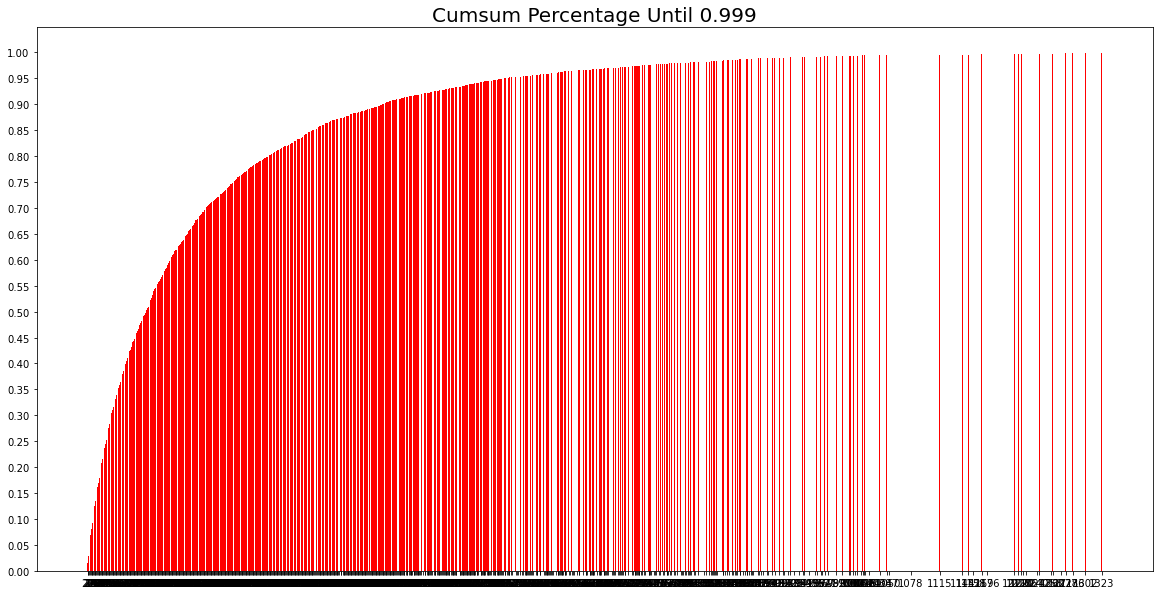

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## Sesstion Time
 - 우리가 다루려는 데이터의 시간 관련 정보를 확인해보자 (구매와 시간의 관계 중요!)

In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


In [12]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.
날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용합니다.



In [13]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
#data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
#data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


## Data Cleansing

1.2에서 살펴보니 길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해줍니다.
너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해줍니다.

In [14]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
data = cleanse_recursive(data, shortest=96, least_click=200)
data

,UserId,ItemId,Rating,Time
130,2,1198,4,2001-01-01 06:28:44
64,2,1210,4,2001-01-01 06:29:11
71,2,1217,3,2001-01-01 06:29:11
134,2,2717,3,2001-01-01 06:29:56
88,2,1293,5,2001-01-01 06:31:01
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


## Train/ Valid/ Test split

모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다.
대회에서 Test Set을 제공해주고 있습니다. 한 번 살펴봅시다.

In [16]:
session_last_time = data.groupby('UserId')['Time'].max()
session_last_time

UserId
2      2001-01-01 07:02:54
5      2000-12-31 16:09:45
8      2000-12-31 16:19:03
9      2000-12-31 10:37:58
10     2001-01-28 08:37:13
               ...        
6035   2000-04-26 10:47:20
6036   2000-04-26 22:19:56
6037   2000-04-27 11:17:20
6039   2000-04-26 23:07:09
6040   2001-08-20 22:44:15
Name: Time, Length: 2712, dtype: datetime64[ns]

In [17]:
final_time = data['Time'].max()
final_time

Timestamp('2003-03-01 02:49:50')

이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.

이번 자료에서는 가장 마지막 100일 기간 동안을 Test로, 30일전부터 1일전 까지를 valid set으로 나누겠습니다.

In [29]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    #session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_train = session_last_time[session_last_time < month_ago - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [30]:
tr, test = split_by_date(data, n_days=30) # 가장 마지막 30일 기간동안 test로
tr, val = split_by_date(tr, n_days=30) #  60일전부터 30일전까지 기간동안 valid set으로

In [31]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t UserId: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [32]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 614196
	 UserId: 2565
	 Items: 1282
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-12-30 11:26:14

* valid Set Stats Info
	 Events: 15987
	 UserId: 46
	 Items: 1277
	 First Time : 2000-05-18 06:07:24
	 Last Time : 2002-12-30 11:26:14

* test Set Stats Info
	 Events: 32878
	 UserId: 81
	 Items: 1282
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [33]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [34]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

논문 
https://arxiv.org/pdf/1511.06939v4.pdf

# 4. Data Pipeline
## Session Dataset 

In [39]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [40]:
#train 데이터로 sessiondataset 객체를 만들고 인스턴스 변수를 살펴보자
#click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있다
#session_idx변수는 각 세션을 인덱싱한 np.array

tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
106,2,1225,5,2001-01-01 06:33:11,5
120,2,1193,5,2001-01-01 06:33:33,6
172,2,318,5,2001-01-01 06:33:33,7
105,2,2858,4,2001-01-01 06:33:54,8
67,2,1213,2,2001-01-01 06:34:18,9


In [41]:
tr_dataset.click_offsets

array([     0,    120,    260, ..., 613817, 613920, 614196], dtype=int32)

In [42]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2562, 2563, 2564])

## Session DataLoader
 - session dataset 객체를 받아 session-parallel mini-batch를 만드는 클래스
 - iter_메소드는 모델 인풋, 라벨, 세션이 끝나는 곳으 위치를 yield 함
 - mask는 후에 RNN Cell State를 초기화 하는데 사용

In [43]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [44]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
106,2,1225,5,2001-01-01 06:33:11,5
120,2,1193,5,2001-01-01 06:33:33,6
172,2,318,5,2001-01-01 06:33:33,7
105,2,2858,4,2001-01-01 06:33:54,8
67,2,1213,2,2001-01-01 06:34:18,9


In [45]:
iter_ex = iter(tr_data_loader)

In [46]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0   3   1 307]
Label Item Idx are :       [  1 120 240 308]
Previous Masked Input Idx are []


# 5. Modeling
## Evaluation Metric 
 - 모델 성능평가를 위한 지표를 보자
 - precision, recall 
 - 모델이 k개의 아이템을 제시했을때 유저가 클릭/구매한 n개의 아이템이 많아야 좋음!
 - recall의 개념 확장한 recall@k 지표, precision의 개념을 확장한 mean average precisio@k 지표등을 사용
 - MBR은 정답 아이템이 나온 순번의 역수값
 - 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질것이고 뒤쪽에 나오거나 안나오면 지표가 낮아짐

In [47]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture


In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [49]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [67]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=6, k=20)

In [68]:
model = create_model(args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 1282)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      200100    
_________________________________________________________________
dropout_4 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (32, 1282)                65382     
Total params: 265,482
Trainable params: 265,482
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [69]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [70]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/19113 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.1] 

	 - Recall@20 epoch 1: 0.299432
	 - MRR@20    epoch 1: 0.082621



Train:   0%|          | 0/19113 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.7] 

	 - Recall@20 epoch 2: 0.345909
	 - MRR@20    epoch 2: 0.104779



Train:   0%|          | 0/19113 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.92]

	 - Recall@20 epoch 3: 0.366591
	 - MRR@20    epoch 3: 0.113867



Train:   0%|          | 0/19113 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.89]

	 - Recall@20 epoch 4: 0.380341
	 - MRR@20    epoch 4: 0.118055



Train:   0%|          | 0/19113 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.71]

	 - Recall@20 epoch 5: 0.387500
	 - MRR@20    epoch 5: 0.122326



Evaluation:  55%|█████▌    | 275/498 [00:31<00:25,  8.61it/s]

	 - Recall@20 epoch 6: 0.393068
	 - MRR@20    epoch 6: 0.124412



## Inference
 - 지금까지 학습한 모델이 테스트셋에 대해 유사한 수준의 성능을 내는지 검증

In [71]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  76%|███████▋  | 783/1024 [01:36<00:29,  8.12it/s]

	 - Recall@20: 0.314256
	 - MRR@20: 0.091593



1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
 - 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
 - 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
 - 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

# 회고
 - Batch 사이즈에 따라 128, 64, 32를 바꿔서 학습을 진행하였으며 메모리 문제로 32에서만 학습이 가능하였다.
 - epoch을 3, 6, 9 바꿔가면서 학습을 시켜봤지만 큰 성능 향상은 없었다.
 - 기간을 바꿔서 해봤지만 특이 변화가 없었다. 데이터 전처리에 방법론이 문제가 있는것같다. ...
 - 어렵다 